### Imports

In [2]:
import os
import pandas as pd
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={"xtick.bottom": True, "ytick.left": True})
from astropy.constants import c, k_B, R_earth
import src.read_database as read_database
import src.map_properties as map_properties
import src.satellite_properties as satellite_properties
import src.store_FOV_indices as store_FOV_indices
import src.Friis as Friis
import src.power_3D_cube as power_3D_cube

%matplotlib inline   

#### Schematic representation of the architecture

![image](./rfi_framework.png)

### Read FM Transmitter Database 

In [3]:
n = str(input("Enter the number of countries to include"))

In [4]:
df = read_database.read_FM_database(countries=read_database.get_countries(n))

### Define frequency range  

In [5]:
freq_range = read_database.get_freq_range()

In [6]:
df = read_database.extract_common_freq(df, freq_range)

### Define resolution of the Healpy map

In [7]:
print('----------- Resolution of the map -----------')

# The default value of nside is 16
nside = int(input("Enter the NSIDE of the healpy map"))
npix, pix_array, phi, theta = map_properties.get_map(nside)

print(f"The number of pixels for the given NSIDE: {(hp.nside2npix(nside))}")
print(f"Approximate resolution in degrees for given nside {np.degrees(hp.nside2resol(nside)):.2f}")
print(f"Pixel area: {hp.nside2pixarea(nside, degrees=True):.2f} square degrees")

----------- Resolution of the map -----------
The number of pixels for the given NSIDE: 3072
Approximate resolution in degrees for given nside 3.66
Pixel area: 13.43 square degrees


### Allocate pixel number to the Latitude and Longitude of each FM transmitter in the database

In [8]:
df, pixel_indices = read_database.allocate_pixel_num(nside, df)

### Define altitude of the satellite orbit 

In [11]:
altitudes = satellite_properties.get_altitudes()

### Calculation of Elevation angle

In [12]:
elev_angle = satellite_properties.calc_elev_angle(npix, phi, theta, altitudes)

/Users/anchal/Downloads/starfire/src/satellite_properties.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  elev_ang[k,i,j]=-(np.degrees(np.arctan((B-np.cos(np.radians(y_ang[i,j])))/np.sin(np.radians(y_ang[i,j])))))
/Users/anchal/Downloads/starfire/src/satellite_properties.py:25: RuntimeWarning: invalid value encountered in arccos
  y_ang[i,j]=(np.arccos(x_ang[i,j]))


### Define radiation pattern of the satellite antenna beam [optional]

In [13]:
beam = satellite_properties.get_beam_pattern("cos square", theta)
az = 0 # Assuming the satellite antenna beam to be symmetric across azimuth

###  Calculation of Field of view (FOV) and Radius of the FOV of the satellite

In [14]:
FOV = satellite_properties.calc_field_of_view(altitudes)

The Field of view of the satellite at a height of 400.00 km is 2.45 radians
The Field of view of the satellite at a height of 3794.73 km is 1.36 radians
The Field of view of the satellite at a height of 36000.00 km is 0.30 radians


In [16]:
Central_angle, Rad_of_FOV = satellite_properties.calc_central_angle(altitudes)

The Radius of the Field of View for a height of 400.00 km in radians is 0.35
The Radius of the Field of View for a height of 3794.73 km in radians is 0.89
The Radius of the Field of View for a height of 36000.00 km in radians is 1.42


# Create power cube 

In [17]:
disc = store_FOV_indices.get_disc(nside, phi, theta, Rad_of_FOV, pix_array)

In [18]:
pix_common = store_FOV_indices.get_common_pix(pix_array, Rad_of_FOV, disc, df)

In [19]:
found_common = store_FOV_indices.get_common_Tx(pixel_indices, pix_common, Rad_of_FOV)

## Plot Healpy map of beam-weighted FOV of a satellite overhead a particular location

<b> Transmitter locations from the FM Transmitter database and the received power at different altitudes has not been taken into account for these plots <b>

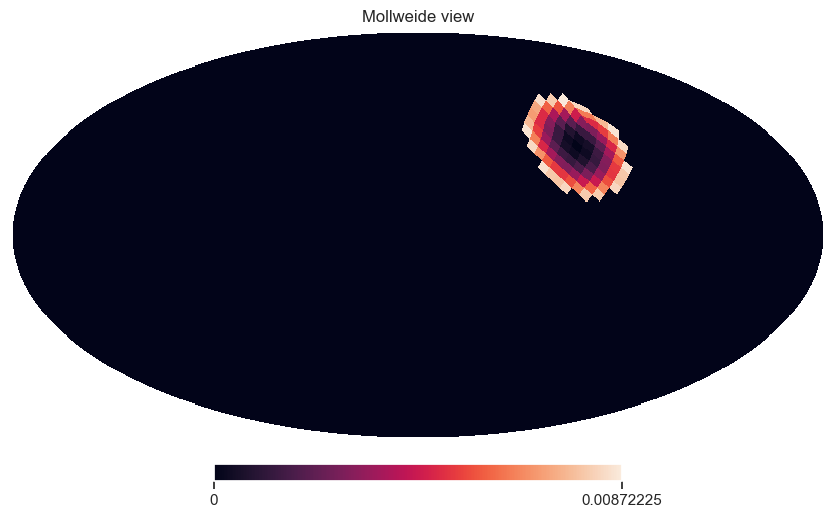

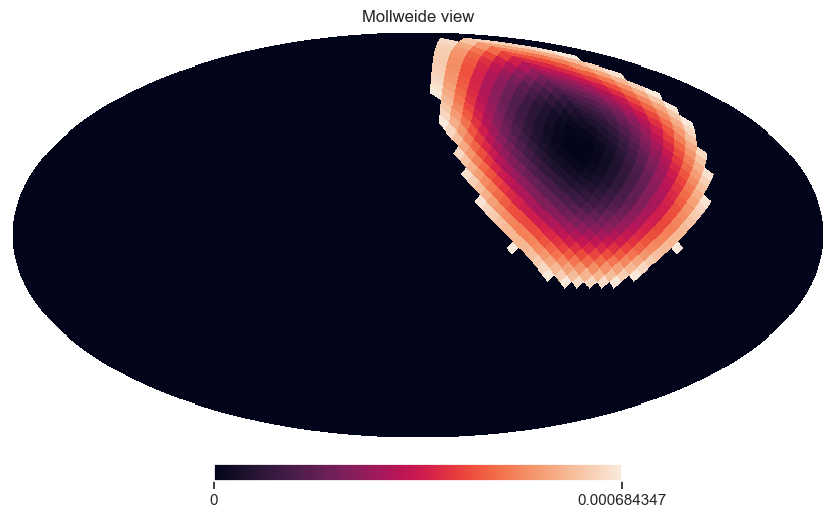

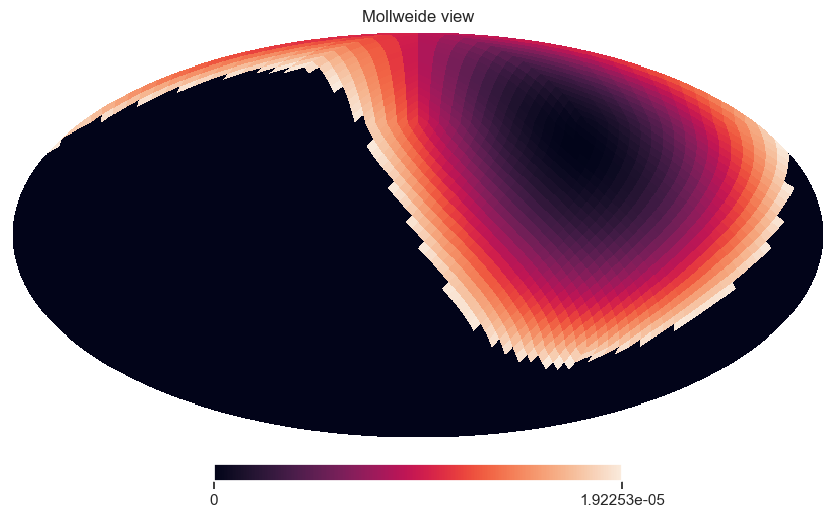

In [20]:
xx4=disc[686][0]  # For Hanle at an altitude of 400 km
xx5=disc[686][1]
xx6=disc[686][2]

y4=satellite_properties.get_beam_pattern("cos square", elev_angle[0,686,xx4])
y5=satellite_properties.get_beam_pattern("cos square", elev_angle[1,686,xx5])
y6=satellite_properties.get_beam_pattern("cos square", elev_angle[2,686,xx6])

data4= np.zeros(hp.nside2npix(nside))
data5= np.zeros(hp.nside2npix(nside))
data6= np.zeros(hp.nside2npix(nside))

data4[xx4]=y4
data5[xx5]=y5

data6[xx6]=y6

hp.mollview(data4,flip='geo')
hp.mollview(data5,flip='geo')
hp.mollview(data6,flip='geo')

In [22]:
Rx_Power_in_Kelvin = Friis.calc_Friis(df, altitudes)[2]

/Users/anchal/Downloads/starfire/src/Friis.py:18: RuntimeWarning: divide by zero encountered in log10
  Rx_Power_in_dBm[j][i]= 10.*np.log10( Rx_Power[j][i])+30
/Users/anchal/Downloads/starfire/src/Friis.py:20: RuntimeWarning: divide by zero encountered in log10
  Rx_Power_in_dBW[j][i]= 10.*np.log10( Rx_Power[j][i])


In [24]:
df_fov = power_3D_cube.get_dataframe_fov(Rx_Power_in_Kelvin, df, found_common, Rad_of_FOV, elev_angle)

In [26]:
power_output = power_3D_cube.get_power_output(npix, Rad_of_FOV, freq_range, df_fov)

## Plot Power Spectrum 

<b> The first index represents altitude of the satellite <b>\
<b> The second index represents location of the satellite(pixel number) <b>\
<b> The third index represents range of frequencies <b>

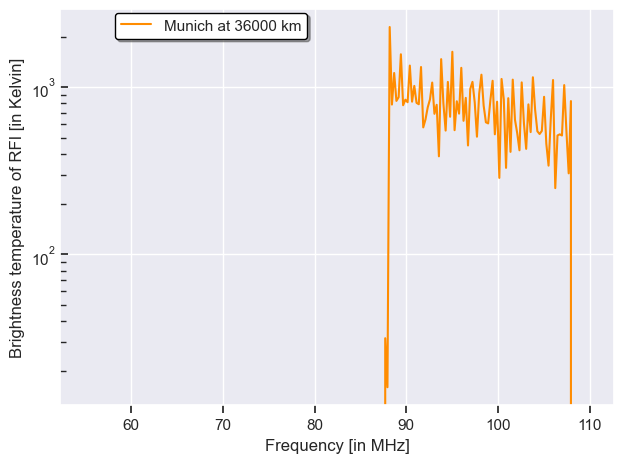

In [28]:
sns.set_style("darkgrid")
sns.set(rc={"xtick.bottom": True, "ytick.left": True,
            "xtick.direction": "out", "ytick.direction": "in"}) #, "axes.edgecolor": "black"})

plt.plot(freq_range,power_output[2,365,:], label='Munich at 36000 km', color='darkorange') 
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Brightness temperature of RFI [in Kelvin]')
plt.yscale('log')
plt.tight_layout()
plt.legend(facecolor="white", edgecolor="black", bbox_to_anchor=(0.46, 1.01),fancybox=True, shadow=True)
# plt.savefig("/home/sonia/Documents/RFI_PAPER/Munich_36000_new.pdf")

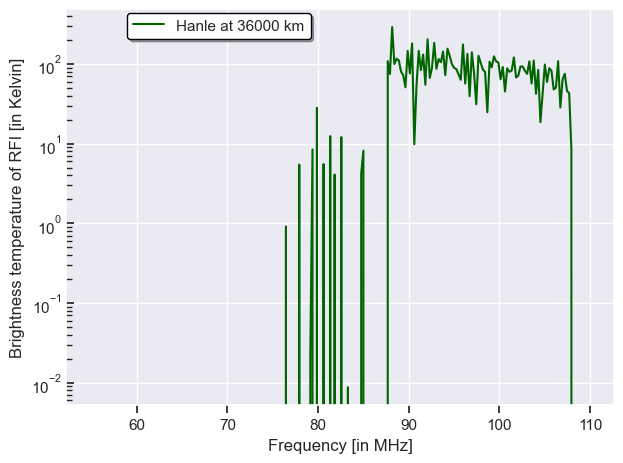

In [30]:
sns.set_style("darkgrid")
sns.set(rc={"xtick.bottom": True, "ytick.left": True,
            "xtick.direction": "out", "ytick.direction": "in"}) #, "axes.edgecolor": "black"})

plt.plot(freq_range,power_output[2,686,:], label='Hanle at 36000 km', color='darkgreen') 
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Brightness temperature of RFI [in Kelvin]')
plt.yscale('log')
plt.tight_layout()
plt.legend(facecolor="white", edgecolor="black", bbox_to_anchor=(0.46, 1.01),fancybox=True, shadow=True)
# plt.savefig("/home/sonia/Documents/RFI_PAPER/Hanle_36000_new.pdf")

In [31]:
num_of_rfi_chan=len(freq_range[power_output[0,13,:]!=0])
num_of_rfi_chan


#NUM_OF_RFI_CHANNEL=96 (Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#NUM_OF_RFI_CHANNEL=84 (Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#NUM_OF_RFI_CHANNEL=0 (Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)



#NUM_OF_RFI_CHANNEL=83 (Pacific Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#NUM_OF_RFI_CHANNEL=3 (Pacific Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#NUM_OF_RFI_CHANNEL=0 (Pacic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)




#NUM_OF_RFI_CHANNEL=96 (Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia)
#NUM_OF_RFI_CHANNEL=84 (Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia)
#NUM_OF_RFI_CHANNEL=0 (Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia)

#NUM_OF_RFI_CHANNEL=83 (Pacific Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia)
#NUM_OF_RFI_CHANNEL=3 (Paciic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia)
#NUM_OF_RFI_CHANNEL=0 (Pacitic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia)





#NUM_OF_RFI_CHANNEL=96 (Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada)
#NUM_OF_RFI_CHANNEL=84 (Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada)
#NUM_OF_RFI_CHANNEL=0 (Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada,)

#NUM_OF_RFI_CHANNEL=83 (Pacific Ocean at 36000 km (Tokyo, USA, Germany,\n Canada,)
#NUM_OF_RFI_CHANNEL=3 (Paciic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada,)
#NUM_OF_RFI_CHANNEL=0 (Pacitic Ocean at 400 km (Tokyo, USA, Germany,\n Canada)







#NUM_OF_RFI_CHANNEL=96 (Arctic Ocean at 36000 km (Tokyo, USA, Germany)
#NUM_OF_RFI_CHANNEL=84 (Arctic Ocean at 3795 km (Tokyo, USA, Germany)
#NUM_OF_RFI_CHANNEL=0 (Arctic Ocean at 400 km (Tokyo, USA, Germany)

#NUM_OF_RFI_CHANNEL=13 (Pacific Ocean at 36000 km (Tokyo, USA, Germany)
#NUM_OF_RFI_CHANNEL=3 (Paciic Ocean at 3795 km (Tokyo, USA, Germany)
#NUM_OF_RFI_CHANNEL=0 (Pacitic Ocean at 400 km (Tokyo, USA, Germany)






#NUM_OF_RFI_CHANNEL=32 (Arctic Ocean at 36000 km (Tokyo, USA)
#NUM_OF_RFI_CHANNEL=12 (Arctic Ocean at 3795 km (Tokyo, USA)
#NUM_OF_RFI_CHANNEL=0 (Arctic Ocean at 400 km (Tokyo, USA)

#NUM_OF_RFI_CHANNEL=12 (Pacific Ocean at 36000 km (Tokyo, USA)
#NUM_OF_RFI_CHANNEL=2 (Paciic Ocean at 3795 km (Tokyo, USA)
#NUM_OF_RFI_CHANNEL=0 (Pacitic Ocean at 400 km (Tokyo, USA)




#NUM_OF_RFI_CHANNEL=31 (Arctic Ocean at 36000 km (Tokyo)
#NUM_OF_RFI_CHANNEL=11 (Arctic Ocean at 3795 km (Tokyo)
#NUM_OF_RFI_CHANNEL=0 (Arctic Ocean at 400 km (Tokyo)

#NUM_OF_RFI_CHANNEL=10 (Pacific Ocean at 36000 km (Tokyo)
#NUM_OF_RFI_CHANNEL=0(Paciic Ocean at 3795 km (Tokyo)
#NUM_OF_RFI_CHANNEL=0 (Pacitic Ocean at 400 km (Tokyo)




8

In [32]:
rfi_band=244*num_of_rfi_chan # in kHz
rfi_band_inMHz=rfi_band*1e-3
rfi_band_inMHz

1.952

array([ 55.   ,  55.244,  55.488,  55.732,  55.976,  56.22 ,  56.464,
        56.708,  56.952,  57.196,  57.44 ,  57.684,  57.928,  58.172,
        58.416,  58.66 ,  58.904,  59.148,  59.392,  59.636,  59.88 ,
        60.124,  60.368,  60.612,  60.856,  61.1  ,  61.344,  61.588,
        61.832,  62.076,  62.32 ,  62.564,  62.808,  63.052,  63.296,
        63.54 ,  63.784,  64.028,  64.272,  64.516,  64.76 ,  65.004,
        65.248,  65.492,  65.736,  65.98 ,  66.224,  66.468,  66.712,
        66.956,  67.2  ,  67.444,  67.688,  67.932,  68.176,  68.42 ,
        68.664,  68.908,  69.152,  69.396,  69.64 ,  69.884,  70.128,
        70.372,  70.616,  70.86 ,  71.104,  71.348,  71.592,  71.836,
        72.08 ,  72.324,  72.568,  72.812,  73.056,  73.3  ,  73.544,
        73.788,  74.032,  74.276,  74.52 ,  74.764,  75.008,  75.252,
        75.496,  75.74 ,  75.984,  76.228,  76.472,  76.716,  76.96 ,
        77.204,  77.448,  77.692,  77.936,  78.18 ,  78.424,  78.668,
        78.912,  79.

In [35]:
tot_band=freq_range[-1]-freq_range[0]
usable_band=tot_band-rfi_band_inMHz
usable_band


#USABLE_BW=31.576(Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#USABLE_BW_CHANNEL=34.504000000000005 (Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#USABLE_BW=55 (Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)

#USABLE_BW=34.748000000000005(PACIFIC Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#USABLE_BW_CHANNEL=54.268(Pacific Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#USABLE_BW=55 (Pacific Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)



#USABLE_BW=31.576(Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia )
#USABLE_BW_CHANNEL=34.504000000000005 (Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia)
#USABLE_BW=55 (Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia )

#USABLE_BW=34.748000000000005(PACIFIC Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia 
#USABLE_BW_CHANNEL=54.268(Pacific Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia)
#USABLE_BW=55 (Pacific Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia)




#USABLE_BW=31.576(Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada)
#USABLE_BW_CHANNEL=34.504000000000005 (Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada)
#USABLE_BW=55 (Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada)

#USABLE_BW=34.748000000000005(PACIFIC Ocean at 36000 km (Tokyo, USA, Germany,\n Canada,
#USABLE_BW_CHANNEL=54.268(Pacific Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, 
#USABLE_BW=55 (Pacific Ocean at 400 km (Tokyo, USA, Germany,\n Canada, )






#USABLE_BW=31.576(Arctic Ocean at 36000 km (Tokyo, USA,, Germany)
#USABLE_BW_CHANNEL=34.504000000000005 (Arctic Ocean at 3795 km (Tokyo, USA, Germany)
#USABLE_BW=55 (Arctic Ocean at 400 km (Tokyo, USA, Germany)

#USABLE_BW=51.828(Pacific Ocean at 36000 km (Tokyo, USA, Germany)
#USABLE_BW_CHANNEL=54.268(Pacifc Ocean at 3795 km (Tokyo, USA, Germany)
#USABLE_BW=55 (Pacific Ocean at 400 km (Tokyo, USA, Germany)





#USABLE_BW=47.192(Arctic Ocean at 36000 km (Tokyo, USA)
#USABLE_BW_CHANNEL=52.072 (Arctic Ocean at 3795 km (Tokyo, USA)
#USABLE_BW=55 (Arctic Ocean at 400 km (Tokyo, USA)

#USABLE_BW=52.072(Pacific Ocean at 36000 km (Tokyo, USA)
#USABLE_BW_CHANNEL=54.512(Pacifc Ocean at 3795 km (Tokyo, USA)
#USABLE_BW=55 (Pacific Ocean at 400 km (Tokyo, USA)





#USABLE_BW=47.436(Arctic Ocean at 36000 km (Tokyo)
#USABLE_BW_CHANNEL=52.316 (Arctic Ocean at 3795 km (Tokyo)
#USABLE_BW=55 (Arctic Ocean at 400 km (Tokyo)

#USABLE_BW=52.56(Pacific Ocean at 36000 km (Tokyo)
#USABLE_BW_CHANNEL=55(Pacifc Ocean at 3795 km (Tokyo)
#USABLE_BW=55 (Pacific Ocean at 400 km (Tokyo)



52.94799999999995

In [36]:
time=1
FOM=time*usable_band
FOM

#FOM=31.576(Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa) 31.576
#FOM=34.504000000000005(Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa) 34.504000000000005
#FOM=55(Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa) 53.048


#FOM=34.748000000000005(Pacific Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa) 34.748000000000005
#FOM=54.268(Paciic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa) 34.748000000000005
#FOM=55(Pacific Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa) 55.0
#---------------------------------------------------------------------------------------------------------

#FOM=31.576(Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia ) 31.576
#FOM=34.504000000000005(Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia )34.504000000000005
#FOM=55(Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia )53.048


#FOM=34.748000000000005(Pacific Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia ) 34.748000000000005
#FOM=54.268(Paciic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia ) 34.748000000000005
#FOM=55(Pacific Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia ) 55

#------------------------------------------------------------------------------------------------------------



#FOM=31.576(Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada) 31.576
#FOM=34.504000000000005(Arctic Ocean at 3795 km (Tokyo, USA, Germany) 34.504000000000005
#FOM=55(Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada,) 53.048


#FOM=34.748000000000005(Pacific Ocean at 36000 km (Tokyo, USA, Germany,\n Canada) 34.748000000000005
#FOM=54.268(Paciic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada ) 34.748000000000005
#FOM=55(Pacific Ocean at 400 km (Tokyo, USA, Germany,\n Canada ) 55

#---------------------------------------------------------------------------------------------------------------

#FOM=31.576(Arctic Ocean at 36000 km (Tokyo, USA, Germany,) 31.576
#FOM=34.504000000000005(Arctic Ocean at 3795 km (Tokyo, USA, Germany) 34.50
#FOM=55(Arctic Ocean at 400 km (Tokyo, USA, Germany) 53.048


#FOM=51.828(Pacific Ocean at 36000 km (Tokyo, USA, Germany) 34.748000000000005
#FOM=54.268(Paciic Ocean at 3795 km (Tokyo, USA, Germany ) 34.748000000000005
#FOM=55(Pacific Ocean at 400 km (Tokyo, USA, Germany) 55

#---------------------------------------------------------------------------------------------------------------


#FOM=47.192(Arctic Ocean at 36000 km (Tokyo, USA,) 31.576
#FOM=52.072(Arctic Ocean at 3795 km (Tokyo, USA) 34.992
#FOM=55(Arctic Ocean at 400 km (Tokyo, USA) 53.048


#FOM=52.072(Pacific Ocean at 36000 km (Tokyo, USA) 34.748
#FOM=54.512(Paciic Ocean at 3795 km (Tokyo, USA )34.748
#FOM=55(Pacific Ocean at 400 km (Tokyo, USA) 55

#------------------------------------------------------------------------------------------------------------


#FOM=47.436(Arctic Ocean at 36000 km (Tokyo,) 47.192
#FOM=52.316(Arctic Ocean at 3795 km (Tokyo) 52.316
#FOM=55(Arctic Ocean at 400 km (Tokyo) 55


#FOM=52.56(Pacific Ocean at 36000 km (Tokyo) 52.316
#FOM=55(Paciic Ocean at 3795 km (Tokyo ) 54.756
#FOM=55(Pacific Ocean at 400 km (Tokyo) 55

52.94799999999995

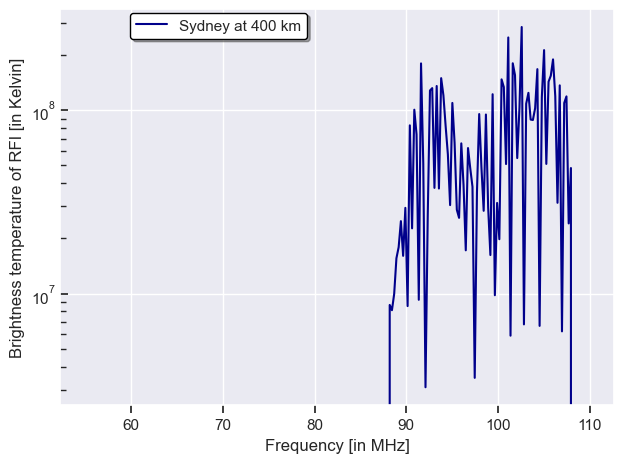

In [38]:
sns.set_style("darkgrid")
sns.set(rc={"xtick.bottom": True, "ytick.left": True,
            "xtick.direction": "out", "ytick.direction": "in"}) #, "axes.edgecolor": "black"})

plt.plot(freq_range,power_output[0,2363,:], label='Sydney at 400 km', color='darkblue') 
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Brightness temperature of RFI [in Kelvin]')
plt.yscale('log')
plt.tight_layout()
plt.legend(facecolor="white", edgecolor="black", bbox_to_anchor=(0.46, 1.01),fancybox=True, shadow=True)

# plt.savefig("/home/sonia/Documents/RFI_PAPER/Sydney_400_new.pdf")

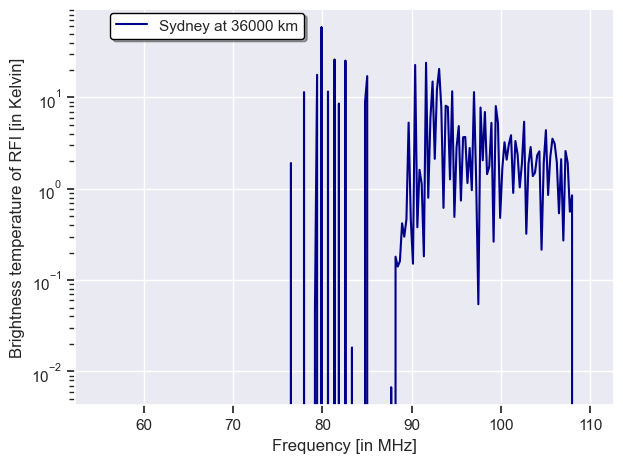

In [39]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={"xtick.bottom": True, "ytick.left": True})

plt.plot(freq_range,power_output[2,2363,:], label='Sydney at 36000 km', color='darkblue') 
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Brightness temperature of RFI [in Kelvin]')
plt.yscale('log')
plt.tight_layout()
plt.legend(facecolor="white", edgecolor="black", bbox_to_anchor=(0.44, 1.01),fancybox=True, shadow=True)
# plt.savefig("/home/sonia/Documents/RFI_PAPER/Sydney_36000_new.pdf")

## Plot Healpy map of brightness temperature of RFI 

In [40]:
test_plot = np.zeros(hp.nside2npix(nside))
test_plot[0:np.size(power_output[0,:,144])] = power_output[0,:,144]

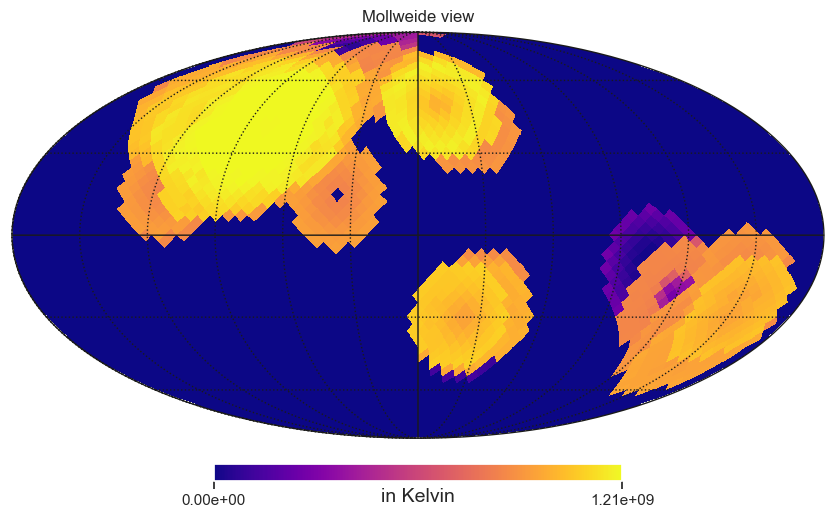

In [41]:
#from healpy.newvisufunc import projview, newprojplot
hp.mollview(test_plot,cmap='plasma',unit="in Kelvin",flip='geo',norm="hist",format= '%.2e',max=1.21e9)
hp.graticule()
sns.set(font_scale=2)
#plt.rcParams.update({'font.size': 105}) # fontsize for colorbar's values

#fontsize = 22
#plt.savefig("/home/sonia/Documents/RFI_PAPER/heatmap400_107_new.pdf")

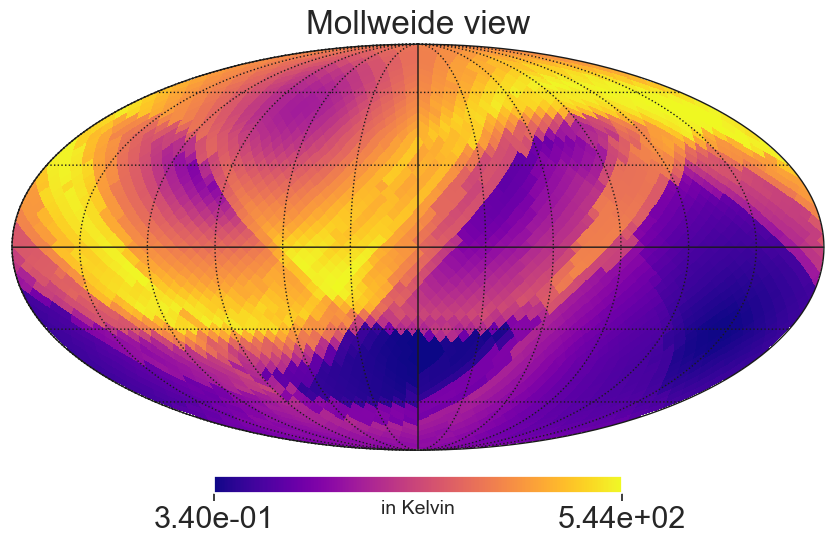

In [42]:
#grayscale_pil_image = Image.open("/home/sonia/Downloads/water_16k.png").convert("L")
#image_array = pil_to_array(grayscale_pil_image)
#theta1 = np.linspace(0, np.pi, num=image_array.shape[0])[:, None]
#phi1 = np.linspace(-np.pi, np.pi, num=image_array.shape[1])
#pix_c = hp.ang2pix(nside, theta1, phi1)
#healpix_map = np.zeros(hp.nside2npix(nside), dtype=np.double)
#healpix_map[pix_c] = image_array
test_plot1 = np.zeros(hp.nside2npix(nside)) 
test_plot1[0:np.size(power_output[2,:,185])] = power_output[2,:,185]
#hp.mollview(healpix_map,cmap='YlGnBu', xsize=2000, flip="geo")
#hp.graticule()
hp.mollview(test_plot1,cmap='plasma',unit="in Kelvin",flip='geo',norm='hist',format= '%.2e')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')

hp.graticule()
#cmap = copy.copy(mpl.cm.get_cmap("inferno"))
#newcm.set_over(newcm(1.0))